In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, normalize, LabelEncoder
from sklearn import model_selection

from scipy import stats
from kmodes.kmodes import KModes
from nltk.stem import SnowballStemmer 

In [2]:
stemmer = SnowballStemmer('english')

def replace(t): #Function for catching what the stemmer misses to further reduce the number of categories (so far only for optimized for base notes) 

    if "amber" in t:
        t = "amber"
    if "cash" in t:
        t = "cashmere"
    if "bean" in t:
        t = "bean"
    if "flo" in t:
        t = "floral"
    if "ced" in t:
        t = "cedar"
    if "mu" in t:
        t = "musk"
    if "leather" in t:
        t = "leather"
    if "lil" in t:
        t = "lily"
    if "lacton" in t:
        t = "lacton"
    if "labda" in t:
        t = "labdanum"
    if "patch" in t:
        t = "patchouli"
    if "vanil" in t:
        t = "vanilla"
    if "oud" in t:
        t = "oud"
    if "oliv" in t:
        t = "olive"
    if "sand" in t:
        t = "sandalwood"
    if "wood" in t[:4]:
        t = "wood"

    return t
            
class ReplaceCountVectorizer(CountVectorizer):
    
     def build_analyzer(self):
        analyzer = super(ReplaceCountVectorizer, self).build_analyzer()
        return lambda doc: ([replace(w) for w in analyzer(doc)])
    
class StemmedCountVectorizer(CountVectorizer): #Builds ontop of sklearn:s CountVectorizer, documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    
     def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(replace(w)) for w in analyzer(doc)]) 

In [3]:
scaler = StandardScaler()
mlb = LabelEncoder()
plt.style.use('seaborn')

df_original = pd.read_csv("data/noon_perfumes_dataset.csv", index_col=0)

df = df_original.copy(deep=True)
df.drop_duplicates(inplace=True)

### Pre-processing

In [4]:
#CONVERT PRICE TO REAL MONEYS
df.old_price = df_original.old_price*0.24
df.new_price = df_original.new_price*0.24

#Create price/ML because sizes range from sample size to large bottles
df['price_ml'] = df['new_price'] / df['ml']
low, high = np.quantile(df['price_ml'],[0.25, 0.75])
df['price'] = np.select([df.price_ml < low, df.price_ml > high], ["cheap", "expensive"], default=["medium"])

In [5]:
#REMOVE THE CHILD AND BINARIZE GENDERS
df.drop(index=df[df.department == 'Kids Unisex'].index, inplace=True)
df.drop(index=df[df.department == 'Unisex'].index, inplace=True)

In [6]:
#REMOVE THE OIL
df.drop(index=df[df.concentration == 'Oil'].index, inplace=True)
df.drop(index=df[df.concentration == 'EDC'].index, inplace=True)

In [7]:
#REMOVE THE PDT
df.drop(index=df[df.concentration == 'PDT'].index, inplace=True)

In [8]:
#REMOVE OUTLIERS
low_rating, high_rating = df.item_rating.quantile(0.01), df.item_rating.quantile(0.99)
low_priceML, high_priceML = df.price_ml.quantile(0.01), df.price_ml.quantile(0.99)

df = df[(df.item_rating >= low_rating) & (df.item_rating <= high_rating)]
df = df[(df.price_ml >= low_priceML) & (df.price_ml <= high_priceML)]

In [9]:
gender = df.department.apply(lambda y: 1 if y == 'Women' else -1)

notes = df[['base_note', 'middle_note']].values
base_note = df['base_note'].values
middle_note = df['middle_note'].values

scents = df['scents'].values
cat_df = df[['brand', 'concentration','scents','price']]

### Kmodes on Daniels code


In [10]:
pricelist = []

for i in range(2,8):
    kmode = KModes(n_clusters=i, init = "random", n_init = 20, random_state=13424)
    kmode.fit(cat_df)
    pricelist.append([i, min(kmode.epoch_costs_)])

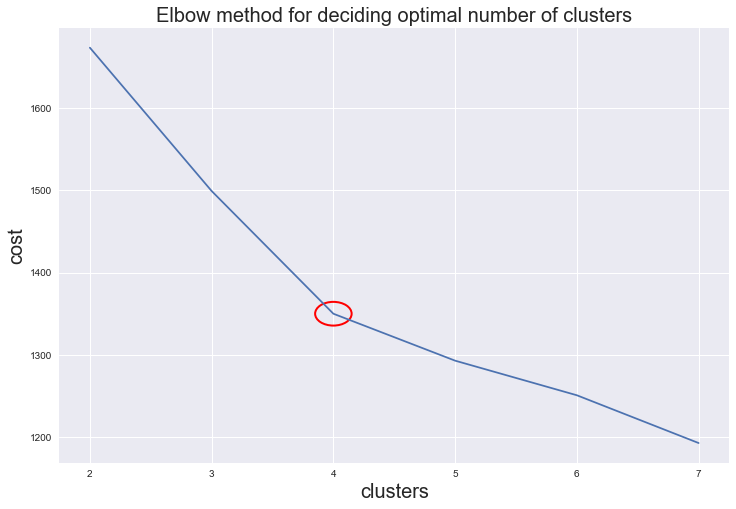

In [11]:
from matplotlib.patches import Ellipse
prices = np.array(pricelist)

fig, ax = plt.subplots(1,1, figsize=(12,8))


ax.plot(prices[:,0], prices[:,1])

scale = np.abs(ax.get_ylim()[0]-ax.get_ylim()[-1])/np.abs(ax.get_xlim()[0]-ax.get_xlim()[-1])
size = 0.3
elbow = Ellipse((prices[2]), size,size*scale, fill=False, color='r', linewidth=2)
plt.ylabel("cost", size=20)
plt.xlabel("clusters", size=20)
plt.title("Elbow method for deciding optimal number of clusters", size=20)
ax.add_patch(elbow)
plt.show()

In [12]:
kmode = KModes(n_clusters=4, max_iter=500, init = "random", 
               n_init = 60, random_state=231)
preds = kmode.fit_predict(cat_df)
print(kmode.cluster_centroids_)

[['GUCCI' 'EDP' 'Floral' 'expensive']
 ['BURBERRY' 'EDP' 'Floral' 'medium']
 ['DORALL COLLECTION' 'EDT' 'Woody' 'cheap']
 ['HUGO BOSS' 'EDT' 'Woody' 'medium']]


In [13]:
df_corr = df.copy()
df_corr.drop(['old_price','new_price','ml','seller_rating','brand','name','department', 'scents', 'base_note', 'middle_note', 'seller','num_seller_ratings','price'], axis=1, inplace=True)
df_corr['gender'] = gender
df_corr['concentration'] = df.concentration.apply(lambda y: 1 if y == 'EDP' else -1)
df_corr[['item_rating', 'price_ml']] = scaler.fit_transform(df_corr[['item_rating','price_ml']])
df_corr['clusters'] = preds

In [14]:
l = 0
df_corr = df_corr[['concentration','gender','item_rating','price_ml','clusters']]
for i in range(len(kmode.cluster_centroids_)):
    
    subset = (df_corr.clusters == i)
    if not l:
        means = df_corr[subset].mean()[:-1]
        l = 1
    else:
        means = np.vstack((means, df_corr[subset].mean()[:-1]))

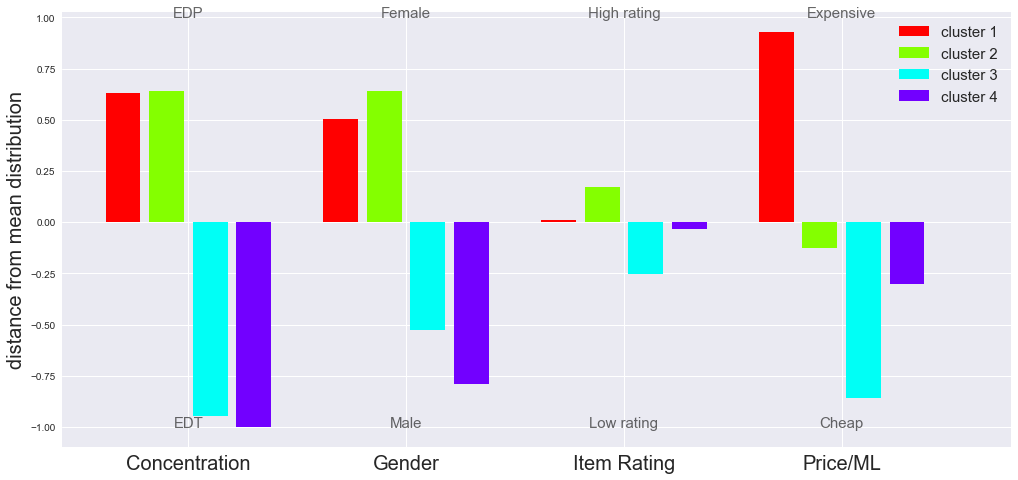

In [15]:
means_spaced = np.hstack((means.T, np.zeros((means.T.shape[0],1)))).flatten()

cmap = cm.hsv
colors = np.resize(np.arange(len(kmode.cluster_centroids_)+1), (means.T.shape[0]+1)*means.T.shape[1])
norm = mpl.colors.Normalize(vmin=min(colors), vmax=max(colors))
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(17,8))
plot = plt.bar(range(len(means_spaced)), means_spaced, color=m.to_rgba(colors))

tick_spacing = np.linspace(0, len(means_spaced), len(means.T)+1)[:-1]+1.5
plt.ylabel("distance from mean distribution", fontsize=20)

plt.xticks(ticks = tick_spacing, labels=['Concentration', 'Gender', 'Item Rating', 'Price/ML'], fontsize=20)
plt.legend(handles=plot[:4],labels=["cluster {}".format(i+1) for i in range(kmode.get_params()['n_clusters'])], fontsize=15)
plt.text(1.5, -1, "EDT", ha='center', fontsize=15, alpha=0.7)
plt.text(1.5, 1, "EDP", ha='center', fontsize=15, alpha=0.7)
plt.text(6.5,1, "Female", ha='center', fontsize=15, alpha=0.7)
plt.text(6.5,-1, "Male", ha='center', fontsize=15, alpha=0.7)
plt.text(11.5,1, "High rating", ha='center', fontsize=15, alpha=0.7)
plt.text(11.5,-1, "Low rating", ha='center', fontsize=15, alpha=0.7)
plt.text(16.5,1, "Expensive", ha='center', fontsize=15, alpha=0.7)
plt.text(16.5,-1, "Cheap", ha='center', fontsize=15, alpha=0.7)
plt.title("");

In [16]:
df_corr.drop(columns=["clusters"],inplace=True)
for i in range(0, max(preds)+1):
    col = pd.Series(preds).apply(lambda y: 1 if y == i else 0)
    df_corr["cluster_{}".format(i+1)] = np.array(col)

df_corr.corr()

,concentration,gender,item_rating,price_ml,cluster_1,cluster_2,cluster_3,cluster_4
concentration,1.000000,0.601469,0.087198,0.330103,0.413305,0.440532,-0.441930,-0.523055
gender,0.601469,1.000000,0.108570,0.239129,0.276784,0.382701,-0.283238,-0.459282
item_rating,0.087198,0.108570,1.000000,0.100626,0.005607,0.114022,-0.121418,-0.018810
price_ml,0.330103,0.239129,0.100626,1.000000,0.587846,-0.084975,-0.409444,-0.160835
cluster_1,0.413305,0.276784,0.005607,0.587846,1.000000,-0.419421,-0.301983,-0.338159
cluster_2,0.440532,0.382701,0.114022,-0.084975,-0.419421,1.000000,-0.317460,-0.355490
cluster_3,-0.441930,-0.283238,-0.121418,-0.409444,-0.301983,-0.317460,1.000000,-0.255953
cluster_4,-0.523055,-0.459282,-0.018810,-0.160835,-0.338159,-0.355490,-0.255953,1.000000


### PLOTTING

In [19]:
vect_base = ReplaceCountVectorizer(max_features = 60, stop_words = ['accord','black','dry','white', 'accords', 'note', 'notes', 'and', 'with', 'of', 'by', 'ectract', 'co', 'essence', 'masculine'])
X1 = vect_base.fit_transform(base_note)

base_names = vect_base.get_feature_names()
base_df = pd.DataFrame(X1.todense(), columns = base_names)
base_df['gender'] = mlb.fit_transform(gender)
base_df[base_df.columns] = scaler.fit_transform(base_df[base_df.columns.values])

mean_prices = []
modes = []

for note in base_names:
    mean = df.price_ml[df['base_note'].str.contains(note, case=False)].mean()
    mode = stats.mode(preds[df['base_note'].str.contains(note, case=False)], nan_policy='omit')[0]
    modes.append(mode)
    mean_prices.append(mean)

/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


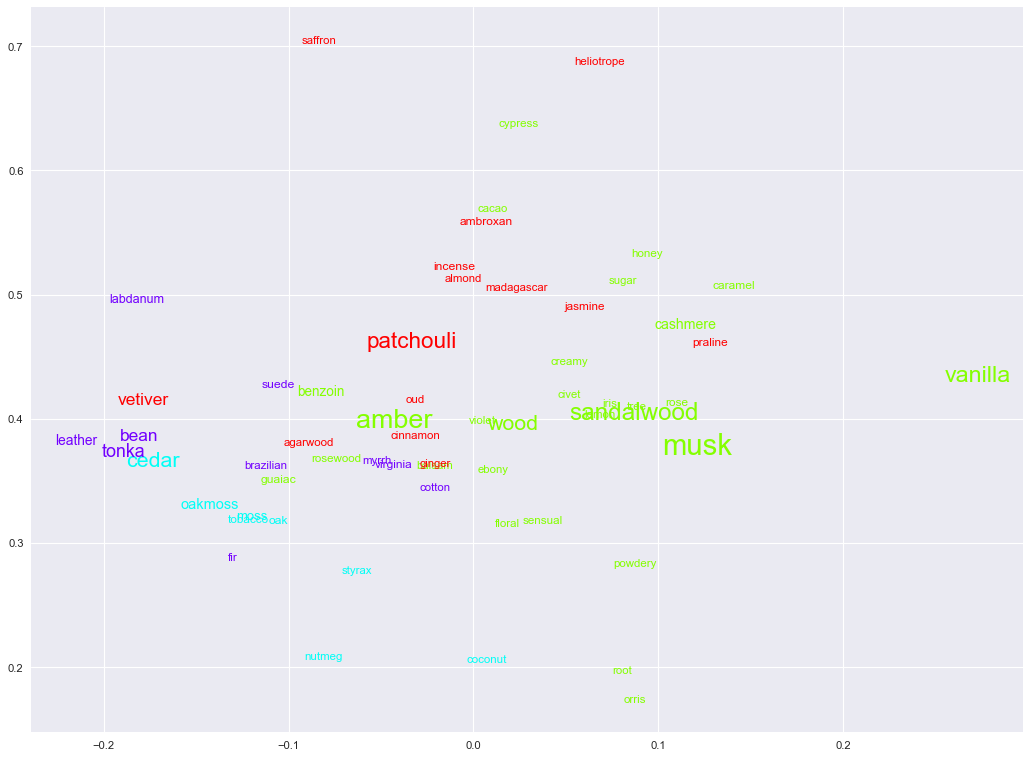

In [20]:
norm = mpl.colors.Normalize(vmin=min(modes)[0], vmax=max(modes)[0]+1)
cmap = cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

X = base_df.corr().iloc[-1][:-1] # Correlation between base notes and gender M/F
Y = mean_prices # Mean price for each
Z = sum(X1.toarray())
plt.figure(figsize=(16, 12), dpi=80)
plt.scatter(X,Y, s =0, c=modes)
for i, d in enumerate(zip(X,Y)):
    plt.annotate(base_names[i], d, ha='center',color=m.to_rgba(int(modes[i])), va='center',fontsize = Z[i]/23 + 10); # Fontsize needs to be scaled, I thought this was optimal to keep everything readable